In [2]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import pickle
import math, cmath
import time as time
import optimized_proj_ev_toolkit as me

from IPython.display import display, Math, Latex

In [9]:
HS_modified = True

class Result(object):
      def __init__(self, ts=None, states=None):
        self.ts = ts
        self.states = states
        self.projrho0_app = None   
        self.projrho_inst_app = None 

def callback(t, rhot):
    global rho
    rho = rhot

def projected_evolution(N, chain_type = "XXX", build_all = False, unitary_ev = False, author=True, x=.5, 
                        gamma = 1*np.e*-2, omega_1=3., omega_2=3., temp=1, 
                        gaussian=False, gr = 2, deltat=10., tmax = 500., distance=me.bures, 
                        do_project=True):
    
    Jx = .15; Jy = .25; Jz = .1; h = 1.

    global rho
    big_list = me.one_body_spin_ops(N)
    loc_globalid = qutip.tensor([qutip.qeye(2) for k in range(N)])

    if (gaussian and gr == 1):
        a = len(me.one_body_spin_ops(N))
        b = len(me.one_body_spin_ops(N)[0])
        coeffs_me1_gr1 = 10**-2.5 * np.full((a,b), 1)
        rho0 = me.initial_state(big_list, N, True, 1, None, coeffs_me1_gr1, None, build_all, False)
        
    elif(gaussian and gr == 2):
        a = len(me.all_two_body_spin_ops(big_list, N))
        b = len(me.all_two_body_spin_ops(big_list, N)[0])

        coeffs_me2_gr2 = 10**-3 * np.full((a,b),1.)
        rho0 = me.initial_state(big_list, N, True, 2, None, coeffs_me2_gr2, None, build_all, False)
             
    elif(not gaussian):
        psi1_list = []
        psi1_list.append(qutip.basis(2,0))
        for n in range(N-1):
            psi1_list.append(qutip.basis(2,1))

        psi0 = qutip.tensor(psi1_list)
        rho0 = me.initial_state(big_list, N, False, None, .5, None, psi0, build_all, False)
         
    if (author):
        basis = me.base_orth(me.n_body_basis(big_list, 2, N), rho0)  ## // Á la Tom
    else: 
        lista_ampliada = []
        for i in range(len(me.n_body_basis(big_list, 1, N))):
            lista_ampliada.append(qutip.tensor(me.n_body_basis(big_list, N,1)[i], qutip.qeye(2)))
        basis = me.base_orth(lista_ampliada, rho0) ## // Á la Mauricio
    
    x_op, p_op, comm_xp, corr_xp, p_dot = me.classical_ops(big_list, chain_type, N, Jx, Jy, Jz, h)
    
    obs = [x_op, p_op, comm_xp, corr_xp, p_dot]
          #, x_op**2,p_op**2, corr_op, p_dot]
        
    sampling = max(int(10*max(1,omega_1, omega_2)*deltat), 10)
    print("sampling:", sampling)
    
    if unitary_ev: 
        c_op_list = None
    else:
        c_op_list = me.spin_dephasing(big_list, N, gamma)
        
    rho = rho0                                                               ## // Á la Mauricio
    approx_exp_vals = [[qutip.expect(op, rho) for op in obs]]
    ts= [0]

    for i in range(int(tmax/deltat)):
        qutip.mesolve(H=me.Heisenberg_Hamiltonian(big_list, chain_type, N, False, Jx, Jy, Jz, h), 
                               rho0=rho, 
                               tlist=np.linspace(0,deltat, sampling), 
                               c_ops=c_op_list, 
                               e_ops=callback,
                               args={'gamma': gamma,'omega_1': omega_1, 'omega_2': omega_2}
                               )
        ts.append(deltat*i)
        if do_project:
            rho = me.proj_op(me.logM(rho), basis, rho0)
            #rho = me.proj_op(me.logM(rho), basis, loc_globalid)
            e0 = max(rho.eigenenergies())
            rho = rho - loc_globalid * e0
            rho = rho.expm()
            trrho = (2.*rho.tr())
            rho = (rho+rho.dag())/trrho

        #print(qutip.entropy.entropy_vn(rho))
        newobs = [qutip.expect(rho, op) for op in obs]
        approx_exp_vals.append(newobs)

    result = {}
    result["ts"] = ts
    result["averages"] = np.array(approx_exp_vals)
    
    if unitary_ev:
        title = f"{chain_type}-chain closed ev/Proj ev for N={N} spins" 
    else:
        title = f"{chain_type}-chain open ev/Proj ev for N={N} spins" 

    #with open(title+".pkl","wb") as f:
    #    pickle.dump(result, f)
    return result, title

# Two-body Gaussian Section

sampling: 30
--- 3.8828868865966797 seconds ---
sampling: 30
--- 5.030774116516113 seconds ---


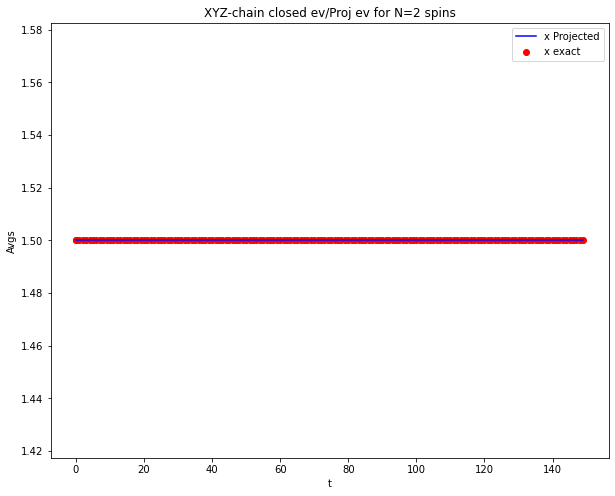

In [10]:
start_time = time.time()

resultsA, title = projected_evolution(2, "XYZ", unitary_ev = True, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=True, 
                              gr = 2, deltat=1, tmax = 150, distance=me.bures,do_project=True)

print("--- %s seconds ---" % (time.time() - start_time))

resultsB, title = projected_evolution(2, "XYZ", unitary_ev = True, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=True, 
                              gr = 2, deltat=1, tmax = 150, distance=me.bures,do_project=False)

print("--- %s seconds ---" % (time.time() - start_time))

plt.figure(figsize=(10, 8))
plt.plot(resultsA["ts"], resultsA["averages"][:,0], label="x Projected", color = "blue")
plt.scatter(resultsB["ts"], resultsB["averages"][:,0], label="x exact", color = "red")

plt.xlabel("t")
plt.ylabel("Avgs")

plt.title(title)
plt.legend()

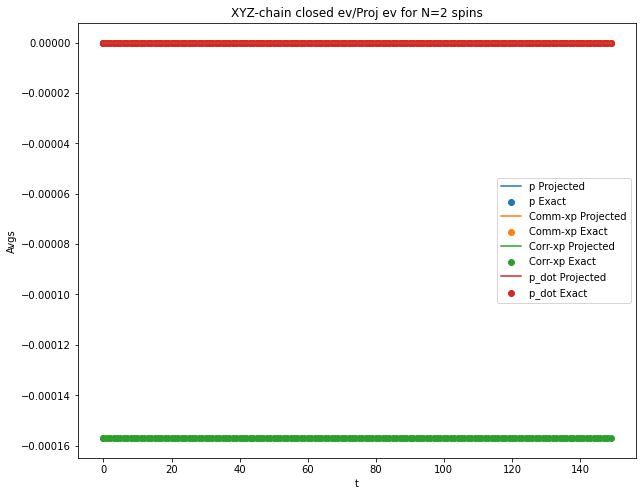

In [11]:
plot_labels = ["p ", "Comm-xp ", "Corr-xp ", "p_dot "]

plt.figure(figsize=(10, 8))
for n in range(4):
    plt.plot(resultsA["ts"], resultsA["averages"][:,n+1], label=plot_labels[n] + "Projected")
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n+1], label=plot_labels[n] + "Exact")
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

sampling: 30
--- 11.377928495407104 seconds ---
sampling: 30
--- 15.434454441070557 seconds ---


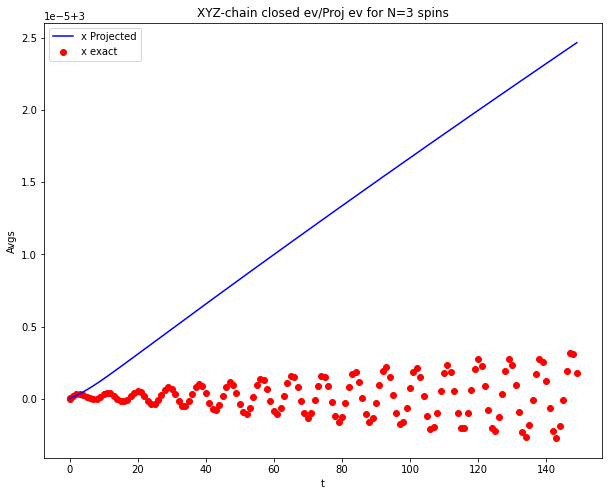

In [12]:
start_time = time.time()

resultsA, title = projected_evolution(3, "XYZ", unitary_ev = True, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=True, 
                              gr = 2, deltat=1, tmax = 150, distance=me.bures,do_project=True)

print("--- %s seconds ---" % (time.time() - start_time))

resultsB, title = projected_evolution(3, "XYZ", unitary_ev = True, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=True, 
                              gr = 2, deltat=1, tmax = 150, distance=me.bures,do_project=False)

print("--- %s seconds ---" % (time.time() - start_time))

plt.figure(figsize=(10, 8))
plt.plot(resultsA["ts"], resultsA["averages"][:,0], label="x Projected", color = "blue")
plt.scatter(resultsB["ts"], resultsB["averages"][:,0], label="x exact", color = "red")

plt.xlabel("t")
plt.ylabel("Avgs")

plt.title(title)
plt.legend()

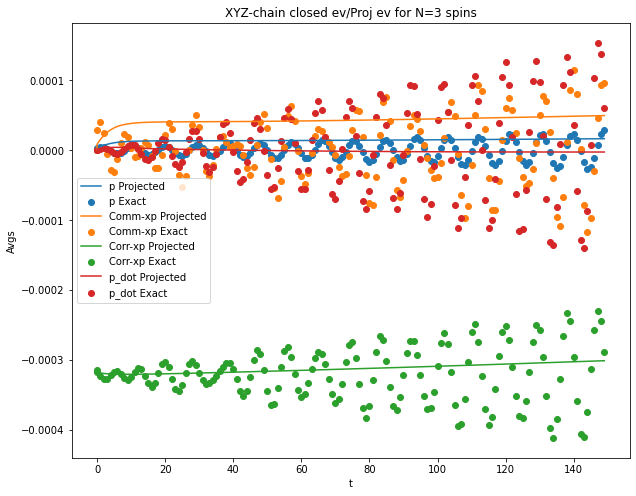

In [13]:
plot_labels = ["p ", "Comm-xp ", "Corr-xp ", "p_dot "]

plt.figure(figsize=(10, 8))
for n in range(4):
    plt.plot(resultsA["ts"], resultsA["averages"][:,n+1], label=plot_labels[n] + "Projected")
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n+1], label=plot_labels[n] + "Exact")
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

sampling: 30
--- 21.578937768936157 seconds ---
sampling: 30
--- 30.299726724624634 seconds ---


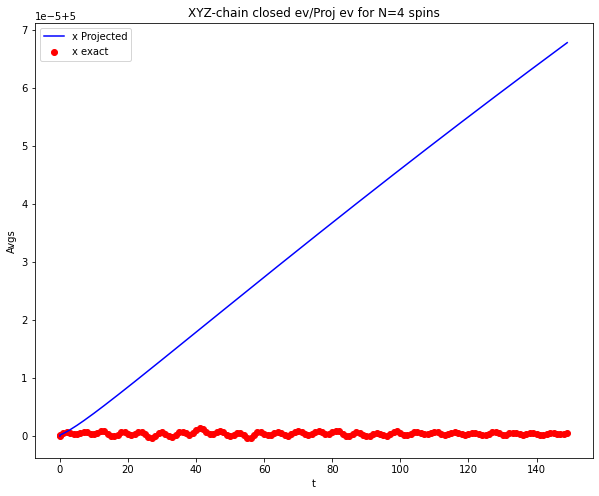

In [14]:
start_time = time.time()

resultsA, title = projected_evolution(4, "XYZ", unitary_ev = True, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=True, 
                              gr = 2, deltat=1, tmax = 150, distance=me.bures,do_project=True)

print("--- %s seconds ---" % (time.time() - start_time))

resultsB, title = projected_evolution(4, "XYZ", unitary_ev = True, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=True, 
                              gr = 2, deltat=1, tmax = 150, distance=me.bures,do_project=False)

print("--- %s seconds ---" % (time.time() - start_time))

plt.figure(figsize=(10, 8))
plt.plot(resultsA["ts"], resultsA["averages"][:,0], label="x Projected", color = "blue")
plt.scatter(resultsB["ts"], resultsB["averages"][:,0], label="x exact", color = "red")

plt.xlabel("t")
plt.ylabel("Avgs")

plt.title(title)
plt.legend()

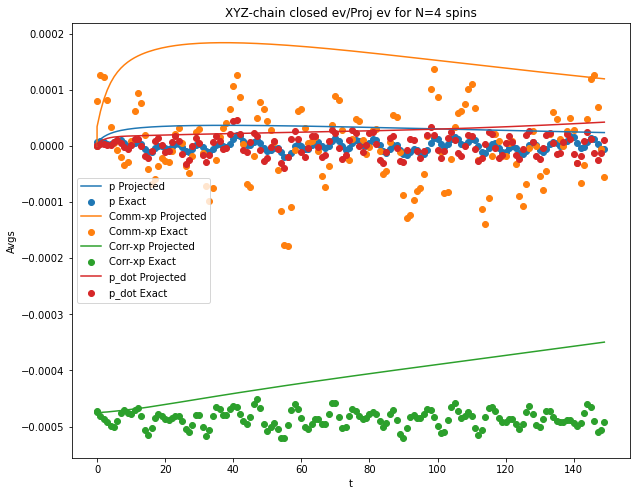

In [15]:
plot_labels = ["p ", "Comm-xp ", "Corr-xp ", "p_dot "]

plt.figure(figsize=(10, 8))
for n in range(4):
    plt.plot(resultsA["ts"], resultsA["averages"][:,n+1], label=plot_labels[n] + "Projected")
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n+1], label=plot_labels[n] + "Exact")
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

sampling: 30
--- 40.07807898521423 seconds ---
sampling: 30
--- 60.208704471588135 seconds ---


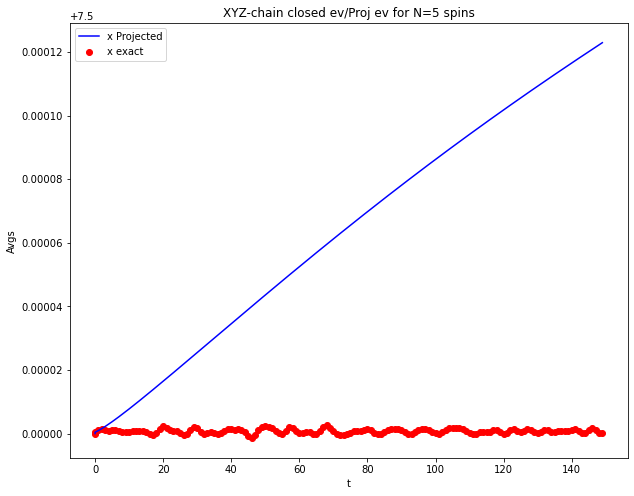

In [16]:
start_time = time.time()

resultsA, title = projected_evolution(5, "XYZ", unitary_ev = True, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=True, 
                              gr = 2, deltat=1, tmax = 150, distance=me.bures,do_project=True)

print("--- %s seconds ---" % (time.time() - start_time))

resultsB, title = projected_evolution(5, "XYZ", unitary_ev = True, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=True, 
                              gr = 2, deltat=1, tmax = 150, distance=me.bures,do_project=False)

print("--- %s seconds ---" % (time.time() - start_time))

plt.figure(figsize=(10, 8))
plt.plot(resultsA["ts"], resultsA["averages"][:,0], label="x Projected", color = "blue")
plt.scatter(resultsB["ts"], resultsB["averages"][:,0], label="x exact", color = "red")

plt.xlabel("t")
plt.ylabel("Avgs")

plt.title(title)
plt.legend()

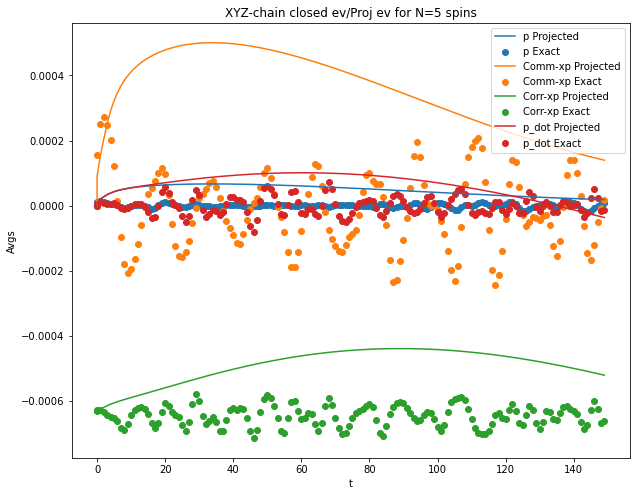

In [17]:
plot_labels = ["p ", "Comm-xp ", "Corr-xp ", "p_dot "]

plt.figure(figsize=(10, 8))
for n in range(4):
    plt.plot(resultsA["ts"], resultsA["averages"][:,n+1], label=plot_labels[n] + "Projected")
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n+1], label=plot_labels[n] + "Exact")
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

sampling: 30
--- 89.6952633857727 seconds ---
sampling: 30
--- 133.34542107582092 seconds ---


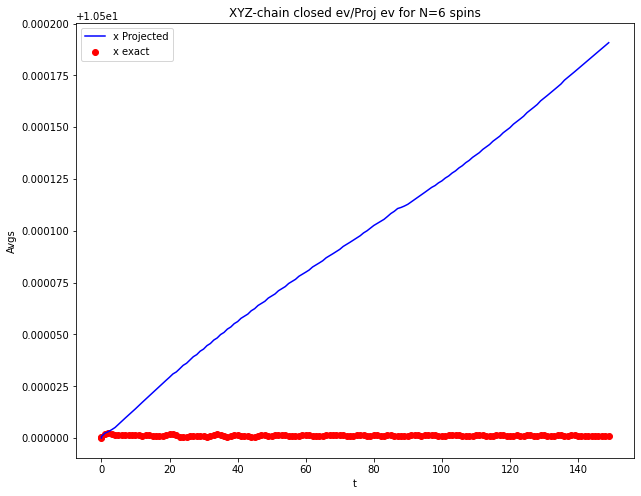

In [18]:
start_time = time.time()

resultsA, title = projected_evolution(6, "XYZ", unitary_ev = True, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=True, 
                              gr = 2, deltat=1, tmax = 150, distance=me.bures,do_project=True)

print("--- %s seconds ---" % (time.time() - start_time))

resultsB, title = projected_evolution(6, "XYZ", unitary_ev = True, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=True, 
                              gr = 2, deltat=1, tmax = 150, distance=me.bures,do_project=False)

print("--- %s seconds ---" % (time.time() - start_time))

plt.figure(figsize=(10, 8))
plt.plot(resultsA["ts"], resultsA["averages"][:,0], label="x Projected", color = "blue")
plt.scatter(resultsB["ts"], resultsB["averages"][:,0], label="x exact", color = "red")

plt.xlabel("t")
plt.ylabel("Avgs")

plt.title(title)
plt.legend()

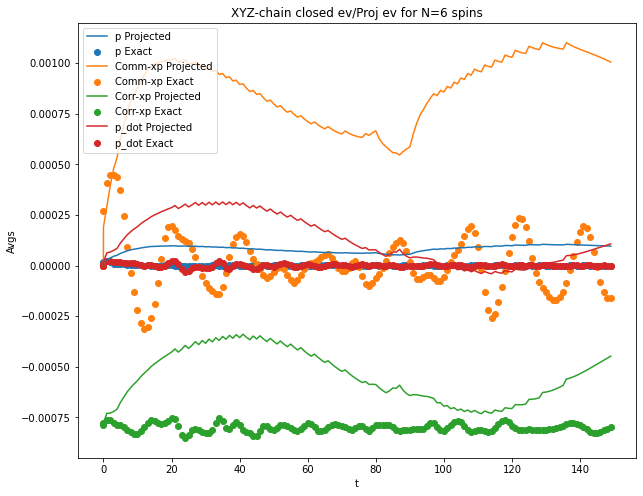

In [19]:
plot_labels = ["p ", "Comm-xp ", "Corr-xp ", "p_dot "]

plt.figure(figsize=(10, 8))
for n in range(4):
    plt.plot(resultsA["ts"], resultsA["averages"][:,n+1], label=plot_labels[n] + "Projected")
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n+1], label=plot_labels[n] + "Exact")
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

sampling: 30
--- 278.22759103775024 seconds ---
sampling: 30
--- 379.1834456920624 seconds ---


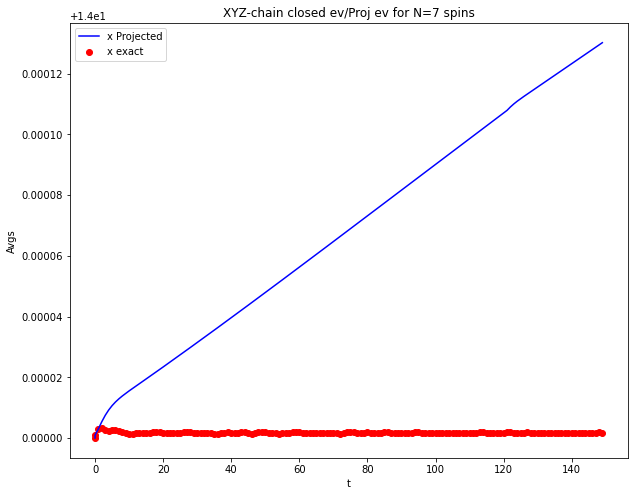

In [25]:
start_time = time.time()

resultsA, title = projected_evolution(7, "XYZ", unitary_ev = True, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=True, 
                              gr = 2, deltat=1, tmax = 150, distance=me.bures,do_project=True)

print("--- %s seconds ---" % (time.time() - start_time))

resultsB, title = projected_evolution(7, "XYZ", unitary_ev = True, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=True, 
                              gr = 2, deltat=1, tmax = 150, distance=me.bures,do_project=False)

print("--- %s seconds ---" % (time.time() - start_time))

plt.figure(figsize=(10, 8))
plt.plot(resultsA["ts"], resultsA["averages"][:,0], label="x Projected", color = "blue")
plt.scatter(resultsB["ts"], resultsB["averages"][:,0], label="x exact", color = "red")

plt.xlabel("t")
plt.ylabel("Avgs")

plt.title(title)
plt.legend()

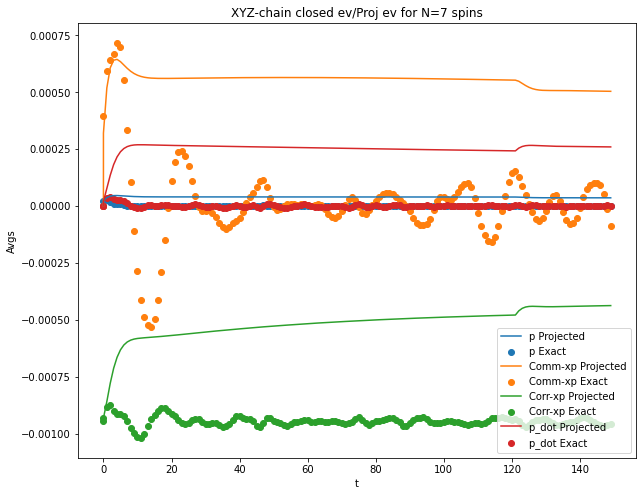

In [26]:
plot_labels = ["p ", "Comm-xp ", "Corr-xp ", "p_dot "]

plt.figure(figsize=(10, 8))
for n in range(4):
    plt.plot(resultsA["ts"], resultsA["averages"][:,n+1], label=plot_labels[n] + "Projected")
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n+1], label=plot_labels[n] + "Exact")
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

In [ ]:
start_time = time.time()

resultsA, title = projected_evolution(8, "XYZ", unitary_ev = True, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=True, 
                              gr = 2, deltat=1, tmax = 150, distance=me.bures,do_project=True)

print("--- %s seconds ---" % (time.time() - start_time))

resultsB, title = projected_evolution(8, "XYZ", unitary_ev = True, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=True, 
                              gr = 2, deltat=1, tmax = 150, distance=me.bures,do_project=False)

print("--- %s seconds ---" % (time.time() - start_time))

plt.figure(figsize=(10, 8))
plt.plot(resultsA["ts"], resultsA["averages"][:,0], label="x Projected", color = "blue")
plt.scatter(resultsB["ts"], resultsB["averages"][:,0], label="x exact", color = "red")

plt.xlabel("t")
plt.ylabel("Avgs")

plt.title(title)
plt.legend()

sampling: 30


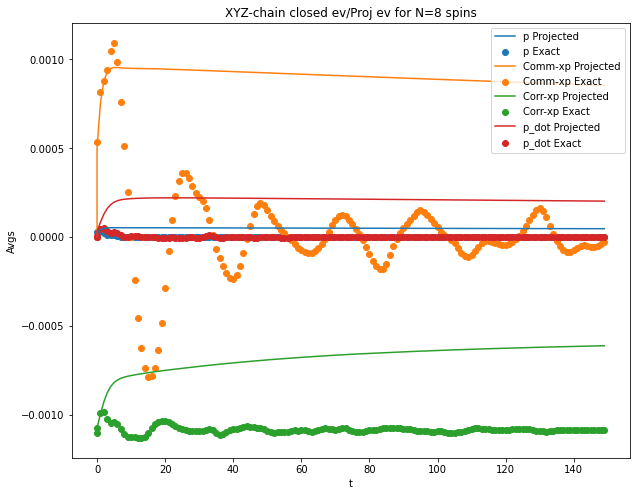

In [23]:
plot_labels = ["p ", "Comm-xp ", "Corr-xp ", "p_dot "]

plt.figure(figsize=(10, 8))
for n in range(4):
    plt.plot(resultsA["ts"], resultsA["averages"][:,n+1], label=plot_labels[n] + "Projected")
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n+1], label=plot_labels[n] + "Exact")
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

In [24]:
start_time = time.time()

resultsA, title = projected_evolution(9, "XYZ", unitary_ev = True, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=False, 
                              gr = None, deltat=1, tmax = 150, distance=me.bures,do_project=True)

print("--- %s seconds ---" % (time.time() - start_time))

resultsB, title = projected_evolution(9, "XYZ", unitary_ev = True, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=False, 
                              gr = None, deltat=1, tmax = 150, distance=me.bures,do_project=False)

print("--- %s seconds ---" % (time.time() - start_time))

plt.figure(figsize=(10, 8))
plt.plot(resultsA["ts"], resultsA["averages"][:,0], label="x Projected", color = "blue")
plt.scatter(resultsB["ts"], resultsB["averages"][:,0], label="x exact", color = "red")

plt.xlabel("t")
plt.ylabel("Avgs")

plt.title(title)
plt.legend()

sampling: 30


LinAlgError: Internal Error.

In [ ]:
plot_labels = ["p ", "Comm-xp ", "Corr-xp ", "p_dot "]

plt.figure(figsize=(10, 8))
for n in range(4):
    plt.plot(resultsA["ts"], resultsA["averages"][:,n+1], label=plot_labels[n] + "Projected")
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n+1], label=plot_labels[n] + "Exact")
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()